In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

C:\Users\baibh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Data Preparation
</h2>

In [2]:
# Loading Train Data
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
# Correcting specific mean pressure value
df.loc[df.index == '2016-03-28', 'meanpressure'] = np.nan
df['meanpressure'].fillna(method='backfill', inplace=True)

In [4]:
# Data Preparation
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear

In [5]:
# Convert to cyclical features
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [6]:
# Additional Lag Features
for lag in range(1, 4):
    df[f'temp_lag_{lag}'] = df['meantemp'].shift(lag)

df.dropna(inplace=True)

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Data Preprocessing
</h2>

In [7]:
# Normalization and Data Splitting
X = df.drop('meantemp', axis=1)
y = df['meantemp']

# Splitting the Data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

In [8]:
# Normalize the features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val = scaler_y.transform(y_val.values.reshape(-1, 1))

In [9]:
# Reshape data for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Model Preparation
</h2>

In [10]:
# Model Architecture with Bidirectional LSTM and Dropout
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(100, activation='relu', return_sequences=True)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 200)              │          90,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 200)              │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 382,233 (1.46 MB)

 Trainable params: 382,233 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - loss: 0.3678 - val_loss: 0.0809 - learning_rate: 0.0010
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0459 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 10/200
3

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 57/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 58/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 59/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 60/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 61/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0028 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 62/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 63/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 64/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_ra

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 112/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 113/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 114/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 115/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 116/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 117/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 118/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 119/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - val_loss: 0.0019 - le

Epoch 166/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 167/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 168/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 169/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 170/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 171/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 172/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 173/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 0.0017 - learning_rate: 1.0000e-04
Epoch 174/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_los

In [12]:
# Evaluate the model
loss = model.evaluate(X_val, y_val)
print(f'Test Loss: {loss}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Test Loss: 0.0016699552070349455


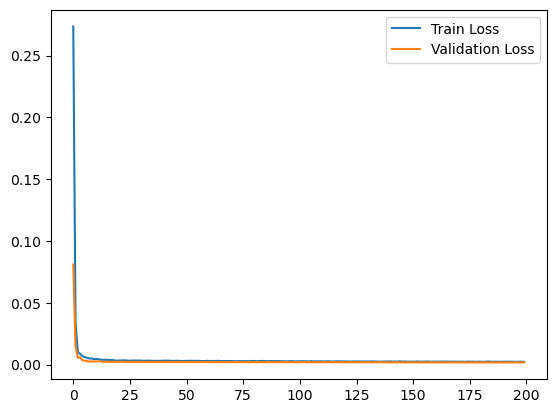

In [13]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

<h2 style="background-color: #000; color: #fff; font-family: Arial, sans-serif; padding: 10px; border-radius: 5px;">
    Model Prediction
</h2>

In [14]:
# Making Prediction
test = pd.read_csv('DailyDelhiClimateTest.csv')
test['date'] = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)

In [15]:
# Correcting specific mean pressure value
test.loc[test.index == '2017-01-01', 'meanpressure'] = np.nan
test['meanpressure'].fillna(method='backfill', inplace=True)

In [16]:
# Data Preparation
test['month'] = test.index.month
test['day_of_year'] = test.index.dayofyear

In [17]:
# Convert to cyclical features
test['sin_month'] = np.sin(2 * np.pi * test['month'] / 12)
test['cos_month'] = np.cos(2 * np.pi * test['month'] / 12)
test['sin_day'] = np.sin(2 * np.pi * test['day_of_year'] / 365)
test['cos_day'] = np.cos(2 * np.pi * test['day_of_year'] / 365)

In [18]:
# Additional Lag Features for Test Data
for lag in range(1, 4):
    test[f'temp_lag_{lag}'] = test['meantemp'].shift(lag)

test.dropna(inplace=True)

In [19]:
y_test = test['meantemp']
X_test = test.drop('meantemp', axis=1)

# Normalize the test features
X_test = scaler_X.transform(X_test)

In [20]:
# Reshape data for LSTM
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Prediction
y_pred_lstm = model.predict(X_test)

# Inverse transform the predictions
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step


In [21]:
# Evaluate predictions
mse_value = mean_squared_error(y_test, y_pred_lstm)
r2_value = r2_score(y_test, y_pred_lstm)
print('MSE: ', mse_value)
print('R²: ', r2_value)

MSE:  2.9014215638584204
R²:  0.9284966801549897


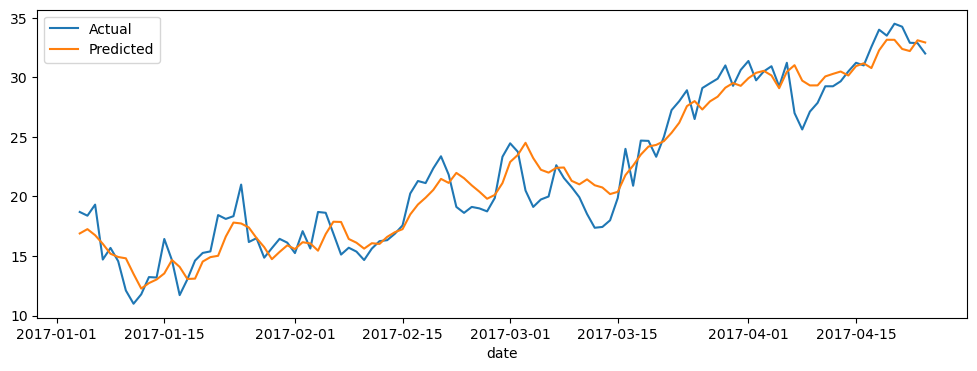

In [22]:
plt.figure(figsize=(12, 4))
sns.lineplot(x=test.index, y=y_test.values, label='Actual')
sns.lineplot(x=test.index, y=y_pred_lstm.flatten(), label='Predicted')
plt.show()